In [239]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import scipy.constants as cs
from scipy.special import wofz
from uncertainties import ufloat
from matplotlib.gridspec import GridSpec

In [240]:
# %pip install seaborn

In [241]:
# Alex's scientific paper style
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import exists
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch
import statistics 
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd

plt.rcParams['text.usetex'] = True

colorList = ['dodgerblue', 'crimson', 'forestgreen', 'darkorange', 'dimgrey', 'purple', 'orchid']
DBlue = [x/256 for x in (4,87,172)]
LB = [x/256 for x in (48,143,172)]
BGreen = [x/256 for x in (55,189,121)]
LG = [x/256 for x in (167,226,55)]
Yellow = [x/256 for x in (244,230,4)]
colorList2 = [DBlue, LB, BGreen, LG, Yellow]

def floatToTex(x):
    return "$"+str(x)+"$"

Fit the peaks from the hydrogen and deuterium lines, and determine the
line centers. From these numbers, you should be able to calculate the ratio of the electron mass
to the nucleon mass.

## Balmer Formula:
$$
\frac{1}{\lambda_n} = R_\infty \left( \frac{1}{2^2} - \frac{1}{n^2} \right)
$$
For our case trying to distinguish between Hydrogen and Deuterium:
$$
\lambda_n^H = \left( 1 + \frac{m_e}{M_P} \right) \lambda_n
$$
$$
\lambda_n^D = \left( 1 + \frac{m_e}{M_D} \right) \lambda_n
$$
We make the reasonable approximation $M_D = 2 M_P$, which introduces a relative error of $5\times 10^{-4}$




## Balmer Series Wavelengths
#### Alpha Line:
$$
\frac{1}{\lambda_3} = R_\infty \left( \frac{1}{2^2} - \frac{1}{3^2} \right) \Rightarrow \lambda_3 = 656.11 \,\text{nm}
$$

$$
\lambda_n^H = \left( 1 + \frac{1}{1836} \right) \lambda_3 \rightarrow \lambda_3^H \approx 656.47 \,\text{nm}
$$

$$
\lambda_3^D = \left( 1 + \frac{1}{2 \cdot 1836} \right) \lambda_3 \approx 656.29 \,\text{nm}
$$

n = 3 corresponds to visible red light!

#### Beta Line:

$$
\frac{1}{\lambda_4} = R_\infty \left( \frac{1}{2^2} - \frac{1}{4^2} \right) \rightarrow \lambda_4 = 486.01 \,\text{nm}
$$

$$
\lambda_4^H = \left( 1 + \frac{1}{1836} \right) \lambda_4 \rightarrow \lambda_4^H \approx 486.27 \,\text{nm}
$$

$$
\lambda_4^D = \left( 1 + \frac{1}{2 \cdot 1836} \right) \lambda_4 \approx 486.14 \,\text{nm}
$$

n = 4 corresponds to visible blue light!

#### Gamma Line:

$$
\frac{1}{\lambda_5} = R_\infty \left( \frac{1}{2^2} - \frac{1}{5^2} \right) \rightarrow \lambda_5 = 433.94 \,\text{nm}
$$

$$
\lambda_5^H = \left( 1 + \frac{1}{1836} \right) \lambda_5 \rightarrow \lambda_5^H \approx 434.17 \,\text{nm}
$$

$$
\lambda_5^D = \left( 1 + \frac{1}{2 \cdot 1836} \right) \lambda_5 \approx 434.05 \,\text{nm}
$$

n = 5 corresponds to visible violet light!

#### Delta Line:

$$
\frac{1}{\lambda_6} = R_\infty \left( \frac{1}{2^2} - \frac{1}{6^2} \right) \rightarrow \lambda_6 = 410.07 \,\text{nm}
$$

$$
\lambda_6^H = \left( 1 + \frac{1}{1836} \right) \lambda_6 \rightarrow \lambda_6^H \approx 410.29 \,\text{nm}
$$

$$
\lambda_6^D = \left( 1 + \frac{1}{2 \cdot 1836} \right) \lambda_6 \approx 410.18 \,\text{nm}
$$

n = 6 corresponds to visible violet light!


## Load and present data: Alpha lines for hydrogen and deuterium

In [242]:
def load_and_process_data(filename, start_step, step_size):
    wavelength_index, voltage = np.loadtxt(filename, skiprows=1, unpack=True)
    print(f"there are {len(wavelength_index)} data points in {filename}")
    spectrometer_value = start_step + (wavelength_index * step_size)
    wavelength = spectrometer_value / 20
    return wavelength, voltage

def plot_data(wavelength, voltage, title="", color_idx=0, peak_wavelengths=None, ax=None, use_frequency=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    if use_frequency:
        # Convert wavelength (nm) to frequency (Hz)
        c = 3e8  # speed of light in m/s
        frequency = c / (wavelength * 1e-9)
        ax.plot(frequency, voltage, marker='o', linestyle='-', color=colorList2[color_idx], alpha=0.7)
        ax.set_xlabel(r'Frequency $f$ [Hz]', fontsize=22, fontweight='bold')
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        ax.xaxis.offsetText.set_fontsize(20)
        
        if peak_wavelengths:
            for peak in peak_wavelengths:
                peak_freq = c / (peak * 1e-9)
                ax.axvline(peak_freq, color='black', linestyle='--', linewidth=2,
                          label=f'Peak: {peak_freq:.2e} Hz')
    else:
        ax.plot(wavelength, voltage, marker='o', linestyle='-', color=colorList2[color_idx], alpha=0.7)
        ax.set_xlabel(r'Wavelength $\lambda$ [nm]', fontsize=22, fontweight='bold')
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        
        if peak_wavelengths:
            for peak in peak_wavelengths:
                ax.axvline(peak, color='black', linestyle='--', linewidth=2,
                          label=f'Peak: {peak:.2f} nm')
    
    ax.set_ylabel(r'Voltage [V]', fontsize=22, fontweight='bold')
    ax.set_title(f"Data for the Hydrogen and Deuterium Balmer Lines ({title})",
                 fontsize=24, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    ax.grid(True, linestyle='--', linewidth=1)
    
    ax.legend()
    return ax

In [243]:
measurements = [
    {
        'filename': 'day3_alphaHD.txt',
        'start_step': 13130,
        'step_size': -0.05,
        'offset': -0.3,
        'peaks': [656.47, 656.29],
        'title': 'Alpha',
        'color_idx': 0
    },
    {
        'filename': 'day3_betaHD.txt',
        'start_step': 9720,
        'step_size': -0.1,
        'offset': -0.76,
        'peaks': [486.27, 486.14],
        'title': 'Beta',
        'color_idx': 1
    },
    {
        'filename': 'day3_gammaHD.txt',
        'start_step': 8670,
        'step_size': -0.1,
        'offset': -0.875,
        'peaks': [434.17, 434.05],
        'title': 'Gamma',
        'color_idx': 2
    },
    {
        'filename': 'day4_delta.txt',
        'start_step': 8191,
        'step_size': -0.1,
        'offset': -0.905,
        'peaks': [410.29, 410.18],
        'title': 'Delta',
        'color_idx': 3
    }
]

In [244]:
# for m in measurements:
#     wavelength, voltage = load_and_process_data(m['filename'], m['start_step'], m['step_size'])
#     peak_wavelengths = [p + m['offset'] for p in m['peaks']]
    
#     fig, ax = plt.subplots(figsize=(12, 8))
#     plot_data(wavelength, voltage, title=m['title'], color_idx=m['color_idx'], ax=ax) #, peak_wavelengths=peak_wavelengths
#     plt.show()

there are 326 data points in day3_alphaHD.txt
there are 203 data points in day3_betaHD.txt
there are 103 data points in day3_gammaHD.txt
there are 83 data points in day4_delta.txt


C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\1451117749.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


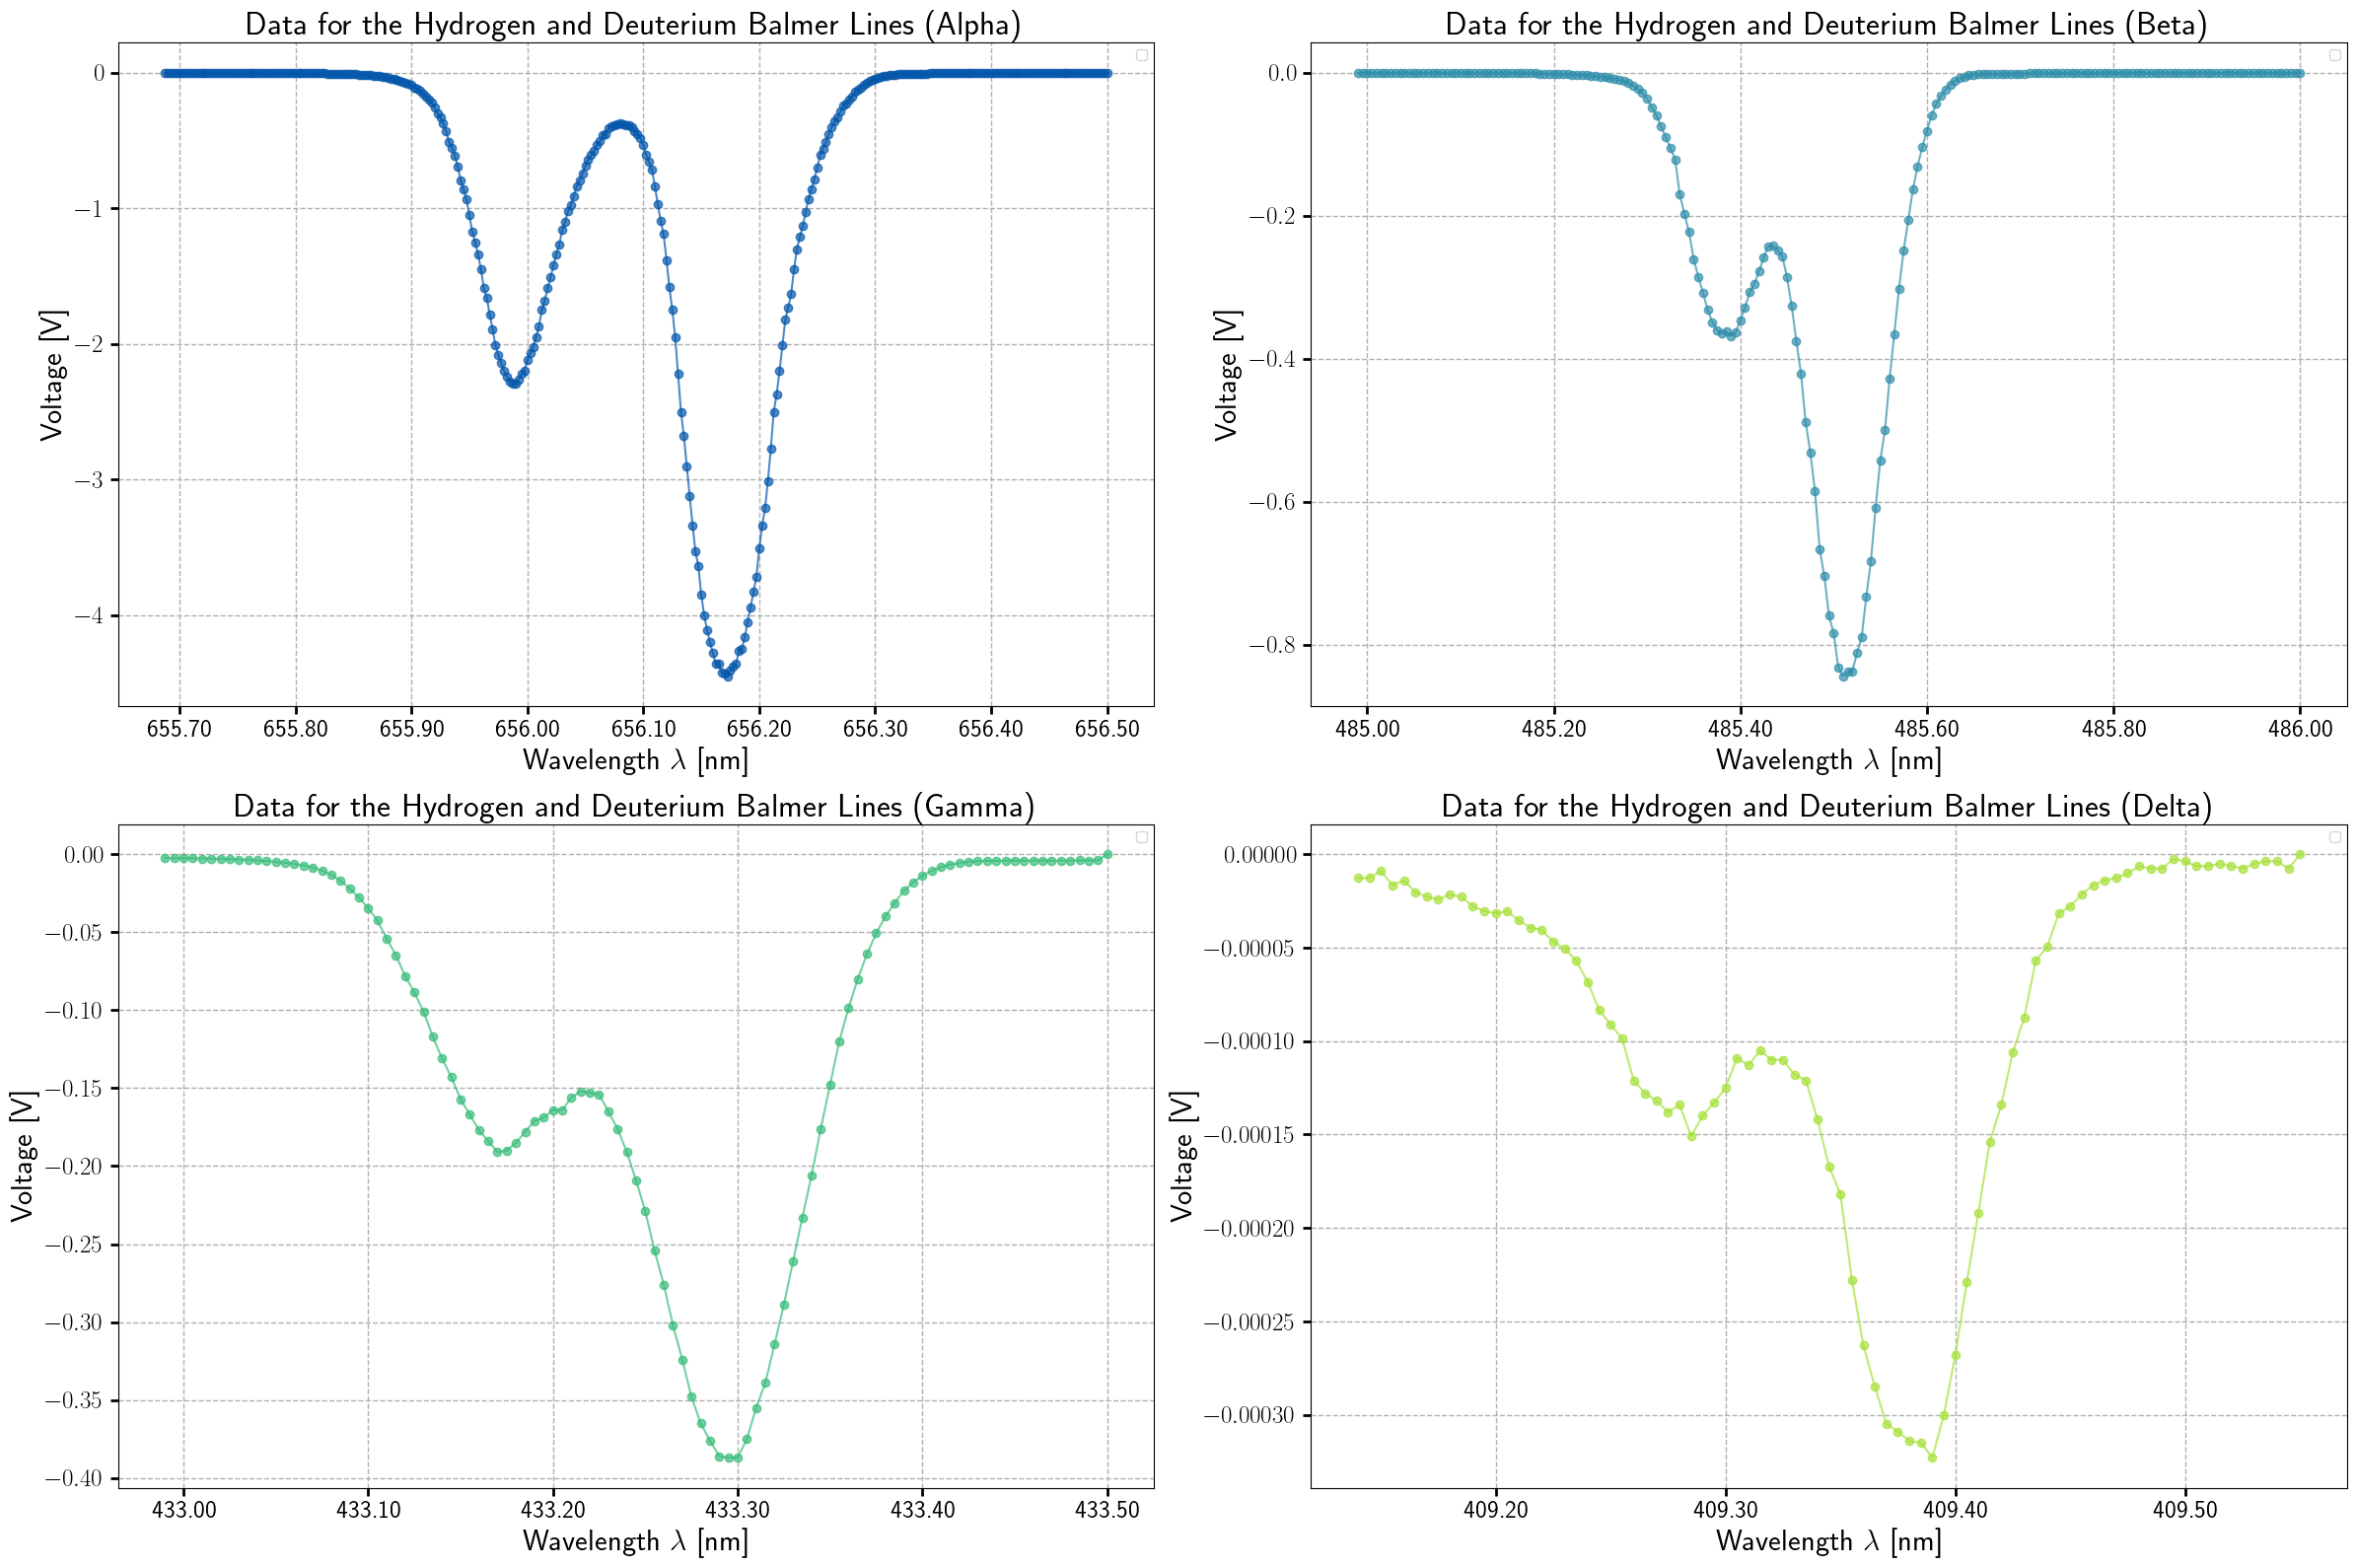

In [245]:
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
axes = axes.ravel()

for m, ax in zip(measurements, axes):
    wavelength, voltage = load_and_process_data(m['filename'], m['start_step'], m['step_size'])
    peak_wavelengths = [p + m['offset'] for p in m['peaks']]
    
    plot_data(wavelength, voltage, title=m['title'], color_idx=m['color_idx'], ax=ax, use_frequency=False) #, peak_wavelengths=peak_wavelengths

plt.tight_layout()
plt.savefig('HD_lines.pdf', bbox_inches='tight')
plt.show()

## Calculating the electron to proton mass ratio
$
    \Delta \lambda_n = \lambda_n^H - \lambda_n^D = \lambda_n m_e \left( \frac{1}{M_P} - \frac{1}{M_D} \right) = \lambda_n \frac{m_e}{M_P} \left( 1 - \frac{M_P}{M_D} \right)
$
<br>
$
\frac{m_e}{M_P} \approx \frac{\Delta \lambda_n}{\lambda_n} \cdot \frac{1}{1 - \frac{M_P}{M_D}} = \frac{\lambda_H- \lambda_D}{\lambda_n} \cdot \frac{1}{1 - \frac{M_P}{M_D}} $
where 
$
\frac{M_P}{M_D} \approx \frac{1}{2} + 2.5 \cdot 10^{-4}
$

In [246]:
def calculate_electron_proton_mass_ratio_old(lambdaD, lambdaH):
    mpmd_ratio = 0.5 + 2.5*10**(-4)
    return abs(lambdaH-lambdaD)/lambdaH*1/(1-mpmd_ratio)
def calculate_electron_proton_mass_ratio(lambdaD, lambdaH, n=3):
    print("calculating electron proton mass ratio with", lambdaD, lambdaH)
    rdydberg = ufloat(10973731.568508, 0.000021)
    mpmd_ratio = 0.5 + 2.5*10**(-4)
    lambda_n = 1/(rdydberg*(1/(2**2)-1/(n**2))) * 1e9  # Convert to nm
    return (lambdaH-lambdaD)/lambda_n*1/(1-mpmd_ratio)

## Peak Fitting
We use scipy curve fit and the uncertainties library to fit our data and calcukate ucnertainties

In [247]:
def fit_double_peak(wavelength, voltage, fit_function, initial_guess, n=3):
    params, covariance = curve_fit(fit_function, wavelength, voltage, p0=initial_guess)
    uncertainties = np.sqrt(np.diag(covariance))
    
    fitted_values = fit_function(wavelength, *params)
    residuals = voltage - fitted_values
    
    param_with_uncertainties = [ufloat(param, unc) for param, unc in zip(params, uncertainties)]
    # mass_ratio_old = calculate_electron_proton_mass_ratio_old(param_with_uncertainties[1], param_with_uncertainties[3 if len(param_with_uncertainties) == 6 else 4])
    mass_ratio = calculate_electron_proton_mass_ratio(param_with_uncertainties[1], param_with_uncertainties[4 if len(param_with_uncertainties) == 6 else 5], n=n)
    
    return params, uncertainties, fitted_values, residuals, mass_ratio, param_with_uncertainties

def plot_double_peak_fit(wavelength, voltage, fit_function, params, residuals, 
                        mass_ratio, param_with_uncertainties, title, fit_title, 
                        color_idx=0, show_residuals=True, label_type='Gaussian',
                        ax1=None, ax2=None, use_frequency=False):
    if ax1 is None:
        if show_residuals:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3, 1])
        else:
            fig, ax1 = plt.subplots(figsize=(12, 6))
    else:
        fig = ax1.figure
    
    if use_frequency:
        # Convert wavelength to frequency
        c = 3e8  # speed of light in m/s
        frequency = c / (wavelength * 1e-9)
        x_data = frequency
        x_label = r'Frequency $f$ [Hz]'
        ax1.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        ax1.xaxis.offsetText.set_fontsize(20)
        ax1.yaxis.offsetText.set_fontsize(20)
    else:
        x_data = wavelength
        x_label = r'Wavelength $\lambda$ [nm]'
        ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    ax1.scatter(x_data, voltage, color=colorList2[color_idx], alpha=0.7, 
                label='Data', s=30)
    
    fitted_curve = fit_function(wavelength, *params)  # Fit is still done in wavelength
    if use_frequency:
        x_fit = frequency
    else:
        x_fit = wavelength
    ax1.plot(x_fit, fitted_curve, color="black", 
             label=f'{fit_title} Fit', linewidth=2)
    
    ax1.set_xlabel(x_label, fontsize=22, fontweight='bold')
    ax1.set_ylabel(r'Voltage [V]', fontsize=22, fontweight='bold')
    ax1.set_title(f"{fit_title} Fit for {title}", fontsize=24, fontweight='bold', pad=20)
    
    if label_type == 'Gaussian':
        param_text = [
            f'$A_1 = {param_with_uncertainties[0]:S} \\, \\mathrm{{V}}$',
            f'$\\mu_1 = {param_with_uncertainties[1]:S} \\, \\mathrm{{nm}}$',
            f'$\\sigma_1 = {param_with_uncertainties[2]:S} \\, \\mathrm{{nm}}$',
            f'$A_2 = {param_with_uncertainties[3]:S} \\, \\mathrm{{V}}$',
            f'$\\mu_2 = {param_with_uncertainties[4]:S} \\, \\mathrm{{nm}}$',
            f'$\\sigma_2 = {param_with_uncertainties[5]:S} \\, \\mathrm{{nm}}$',
            f'$m_e/m_p = {mass_ratio:S}$',
            f'(Expected: ${1/1836:.6f}$)'
        ]
    elif label_type == 'Lorentzian':
        param_text = [
            f'$A_1 = {param_with_uncertainties[0]:S} \\, \\mathrm{{V}}$',
            f'$\\mu_1 = {param_with_uncertainties[1]:S} \\, \\mathrm{{nm}}$',
            f'$G_1 = {param_with_uncertainties[2]:S} \\, \\mathrm{{nm}}$',
            f'$A_2 = {param_with_uncertainties[3]:S} \\, \\mathrm{{V}}$',
            f'$\\mu_2 = {param_with_uncertainties[4]:S} \\, \\mathrm{{nm}}$',
            f'$G_2 = {param_with_uncertainties[5]:S} \\, \\mathrm{{nm}}$',
            f'$m_e/m_p = {mass_ratio:S}$',
            f'(Expected: ${1/1836:.6f}$)'
        ]
    elif label_type == 'Voigt':
        param_text = [
            f'$A_1 = {param_with_uncertainties[0]:S} \\, \\mathrm{{V}}$',
            f'$\\mu_1 = {param_with_uncertainties[1]:S} \\, \\mathrm{{nm}}$',
            f'$\\sigma_1 = {param_with_uncertainties[2]:S} \\, \\mathrm{{nm}}$',
            f'$G_1 = {param_with_uncertainties[3]:S} \\, \\mathrm{{nm}}$',
            f'$A_2 = {param_with_uncertainties[4]:S} \\, \\mathrm{{V}}$',
            f'$\\mu_2 = {param_with_uncertainties[5]:S} \\, \\mathrm{{nm}}$',
            f'$\\sigma_2 = {param_with_uncertainties[6]:S} \\, \\mathrm{{nm}}$',
            f'$G_2 = {param_with_uncertainties[7]:S} \\, \\mathrm{{nm}}$',
            f'$m_e/m_p = {mass_ratio:S}$',
            f'(Expected: ${1/1836:.6f}$)'
        ]
    else:
        raise ValueError("Invalid label type")
    
    for text in param_text:
        ax1.plot([], [], ' ', label=text)
    
    ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(fontsize=13, frameon=True, fancybox=True, framealpha=0.9)
    
    if show_residuals:
        if ax2 is not None:
            ax2.scatter(x_data, residuals, color=colorList2[color_idx], 
                       alpha=0.7, s=30, label='Residuals')
            ax2.axhline(0, color='black', linestyle='--', linewidth=1)
            
            ax2.set_xlabel(x_label, fontsize=22, fontweight='bold')
            ax2.set_ylabel(r'Residuals [V]', fontsize=22, fontweight='bold')
            ax2.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
            ax2.grid(True, linestyle='--', alpha=0.5)
            if use_frequency:
                ax2.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
                ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                ax2.xaxis.offsetText.set_fontsize(20)
                ax2.yaxis.offsetText.set_fontsize(20)
            else:
                ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
            ax2.legend(fontsize=14, frameon=True, fancybox=True, framealpha=0.9)
    
    if ax1 is None:
        plt.tight_layout()
        
    return fig, ax1, ax2 if show_residuals else ax1

### Double Gaussian

If this were a perfect world, we would expect to see 2 dirac delta functions (or actually 7). But of course the world is not perfect. Thus, our best way to go is to first try to fit 2 Gaussians to find the 2 peak wavelengths of the Hydrogenn and Deuterium alpha lines. 

$$f(\lambda) = A_1 e^{-\frac{(\lambda - \mu_1)^2}{2\sigma_1^2}} + A_2 e^{-\frac{(\lambda - \mu_2)^2}{2\sigma_2^2}}$$

In [248]:
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2)) + A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))

### Double Lorentzian
The Lorentz distribution function is given by: 

$$
L(x) = \frac{1}{\pi} \frac{\frac{1}{2} \Gamma}{(x - x_0)^2 + \left(\frac{1}{2} \Gamma\right)^2}
$$
where $\Gamma$ represents the FWHM. 
The double lorentzian can be repressented by: 
$$
L(x) = \frac{A_1}{\pi} \frac{\frac{1}{2} \Gamma_1}{(x - x_1)^2 + \left(\frac{1}{2} \Gamma_1\right)^2} + \frac{A_2}{\pi} \frac{\frac{1}{2} \Gamma_2}{(x - x_2)^2 + \left(\frac{1}{2} \Gamma_2\right)^2}
$$

In [249]:
def double_lorentzian(x, A1, x1, G1, A2, x2, G2):
    """
    x: Wavelengths.
    A1: Amplitude of the first Lorentzian.
    G1: FWHM of the first Lorentzian.
    x1: Center of the first Lorentzian.
    A2: Amplitude of the second Lorentzian.
    G2: FWHM of the second Lorentzian.
    x2: Center of the second Lorentzian.
    """
    L1 = A1*(G1/2) / (np.pi * ((x - x1)**2 + (G1 / 2)**2))
    L2 = A2*(G2/2) / (np.pi * ((x - x2)**2 + (G2 / 2)**2))
    return L1 + L2

### Double Voigt
$$
V(x) = \frac{A_1}{\sigma_1 \sqrt{2\pi}} \operatorname{Re} \left( w \left( \frac{x - x_1 + iG_1}{\sigma_1 \sqrt{2}} \right) \right) + \frac{A_2}{\sigma_2 \sqrt{2\pi}} \operatorname{Re} \left( w \left( \frac{x - x_2 + iG_2}{\sigma_2 \sqrt{2}} \right) \right)
$$

In [250]:
def double_voigt(x, A1, x1, sigma1, G1, A2, x2, sigma2, G2):
    """
    x Wavelengths.
    A: Amplitude of the peak.
    xi: Center of the peak.
    sigma: Standard deviation of the Gaussian component.
    Gi: Full-width at half-maximum of the Lorentzian component.
    """
    z1 = A1 * np.real(wofz((x - x1 + 1j*G1)/sigma1/np.sqrt(2))) / (sigma1*np.sqrt(2*np.pi))
    z2 = A2 * np.real(wofz((x - x2  + 1j*G2)/sigma2/np.sqrt(2))) / (sigma2*np.sqrt(2*np.pi))
    return z1 + z2

In [251]:
def get_data_parameters(transition_type):
    parameters = {
        'alpha_old': {
            'filename': 'ALPHA_HD.txt',
            'start_step': 13100,
            'step_size': 0.1,
            'initial_guesses': {
                'gaussian': [-0.1, 655.4, 0.5, -0.3, 655.6, 0.1],
                'lorentzian': [-0.1, 655.4, 0.5, -0.3, 655.6, 0.1],
                'voigt': [-0.1, 655.9, 0.04, 0.04, -0.4, 656.2, 0.05, 0.05]
            }
        },
        'alpha': {
            'filename': 'day3_alphaHD.txt',
            'start_step': 13130,
            'step_size': -0.05,
            'initial_guesses': {
                'gaussian': [-0.1, 655.4, 0.5, -0.3, 655.6, 0.1],
                'lorentzian': [-0.05, 655.9, 0.1, -0.05, 656.1, 0.1],
                'voigt': [-0.1, 655.9, 0.04, 0.04, -0.4, 656.2, 0.05, 0.05]
            }
        },
        
        'beta': {
            'filename': 'day3_betaHD.txt',
            'start_step': 9720,
            'step_size': -0.1,
            'initial_guesses': {
                'gaussian': [-0.1, 485.4, 0.5, -0.3, 485.5, 0.1],
                'lorentzian': [-0.1, 485.4, 0.5, -0.3, 485.5, 0.1],
                'voigt': [-0.4, 485.4, 0.05, 0.05, -0.8, 485.5, 0.05, 0.05]
            }
        },
        'gamma': {
            'filename': 'day3_gammaHD.txt',
            'start_step': 8670,
            'step_size': -0.1,
            'initial_guesses': {
                'gaussian': [-0.2, 433.15, 0.05, -0.4, 433.3, 0.05],
                'lorentzian': [-0.2, 433.15, 0.05, -0.4, 433.3, 0.05],
                'voigt': [-0.2, 433.15, 0.05, 0.05, -0.4, 433.3, 0.05, 0.05]
            }
        },
        'delta': {
            'filename': 'day4_delta.txt',
            'start_step': 8191,
            'step_size': -0.1,
            'initial_guesses': {
                'gaussian': [-0.00015, 409.28, 0.005, -0.0003, 409.38, 0.005],
                'lorentzian': [-0.00015, 409.28, 0.005, -0.0003, 409.38, 0.005],
                'voigt': [-0.00015, 409.28, 0.005, 0.005, -0.0003, 409.38, 0.005, 0.005]
            }
        }
    }
    return parameters[transition_type]

In [252]:
def fit_all_peak_types(wavelength, voltage, transition_type, n=3):
    params = get_data_parameters(transition_type)
    
    fit_functions = {
        'gaussian': (double_gaussian, params['initial_guesses']['gaussian'], 'Gaussian'),
        'lorentzian': (double_lorentzian, params['initial_guesses']['lorentzian'], 'Lorentzian'),
        'voigt': (double_voigt, params['initial_guesses']['voigt'], 'Voigt')
    }
    
    results = {}
    for fit_type, (func, guess, label_type) in fit_functions.items():
        params, uncertainties, fitted_values, residuals, mass_ratio, param_with_uncertainties = fit_double_peak(
            wavelength, voltage, func, guess, n=n
        )
        results[fit_type] = {
            'function': func,
            'params': params,
            'residuals': residuals,
            'mass_ratio': mass_ratio,
            'param_with_uncertainties': param_with_uncertainties,
            'label_type': label_type
        }
    
    return results

In [253]:
def plot_all_fits(transition_type, show_residuals=True, combined=False, n=3, use_frequency=False):
    params = get_data_parameters(transition_type)
    wavelength, voltage = load_and_process_data(
        params['filename'],
        params['start_step'],
        params['step_size']
    )
   
    results = fit_all_peak_types(wavelength, voltage, transition_type, n=n)
   
    if combined:
        if show_residuals:
            fig = plt.figure(figsize=(26, 12))  
            
            gs = GridSpec(2, 3, figure=fig, height_ratios=[3, 1], hspace=0.3)
            
            main_axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
            resid_axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
            axes = np.array([main_axes, resid_axes])
        else:
            fig, axes = plt.subplots(1, 3, figsize=(16, 6))
       
        for idx, (fit_type, result) in enumerate(results.items()):
            if show_residuals:
                ax1, ax2 = axes[:, idx]
            else:
                ax1 = axes[idx]
                ax2 = None
           
            plot_double_peak_fit(
                wavelength, voltage, result['function'],
                result['params'], result['residuals'], result['mass_ratio'],
                result['param_with_uncertainties'],
                title=f"H+D {transition_type.capitalize()} Balmer Lines",
                fit_title=result['label_type'],
                color_idx=idx,
                show_residuals=show_residuals,
                label_type=result['label_type'],
                ax1=ax1,
                ax2=ax2,
                use_frequency=use_frequency
            )
       
        plt.tight_layout()
        return fig, axes
    else:
        figures = []
        for idx, (fit_type, result) in enumerate(results.items()):
            fig, ax1, ax2 = plot_double_peak_fit(
                wavelength, voltage, result['function'],
                result['params'], result['residuals'], result['mass_ratio'],
                result['param_with_uncertainties'],
                title=f"Hydrogen and Deuterium {transition_type.capitalize()} Balmer Lines",
                fit_title=result['label_type'],
                color_idx=idx,
                show_residuals=show_residuals,
                label_type=result['label_type'],
                use_frequency=use_frequency
            )
            figures.append(fig)
       
        return figures

there are 326 data points in day3_alphaHD.txt
calculating electron proton mass ratio with 655.99186+/-0.00031 656.17395+/-0.00016
calculating electron proton mass ratio with 655.9887+/-0.0009 656.1736+/-0.0005
calculating electron proton mass ratio with 655.99118+/-0.00030 656.17382+/-0.00015


C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\2374029236.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\1911101405.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


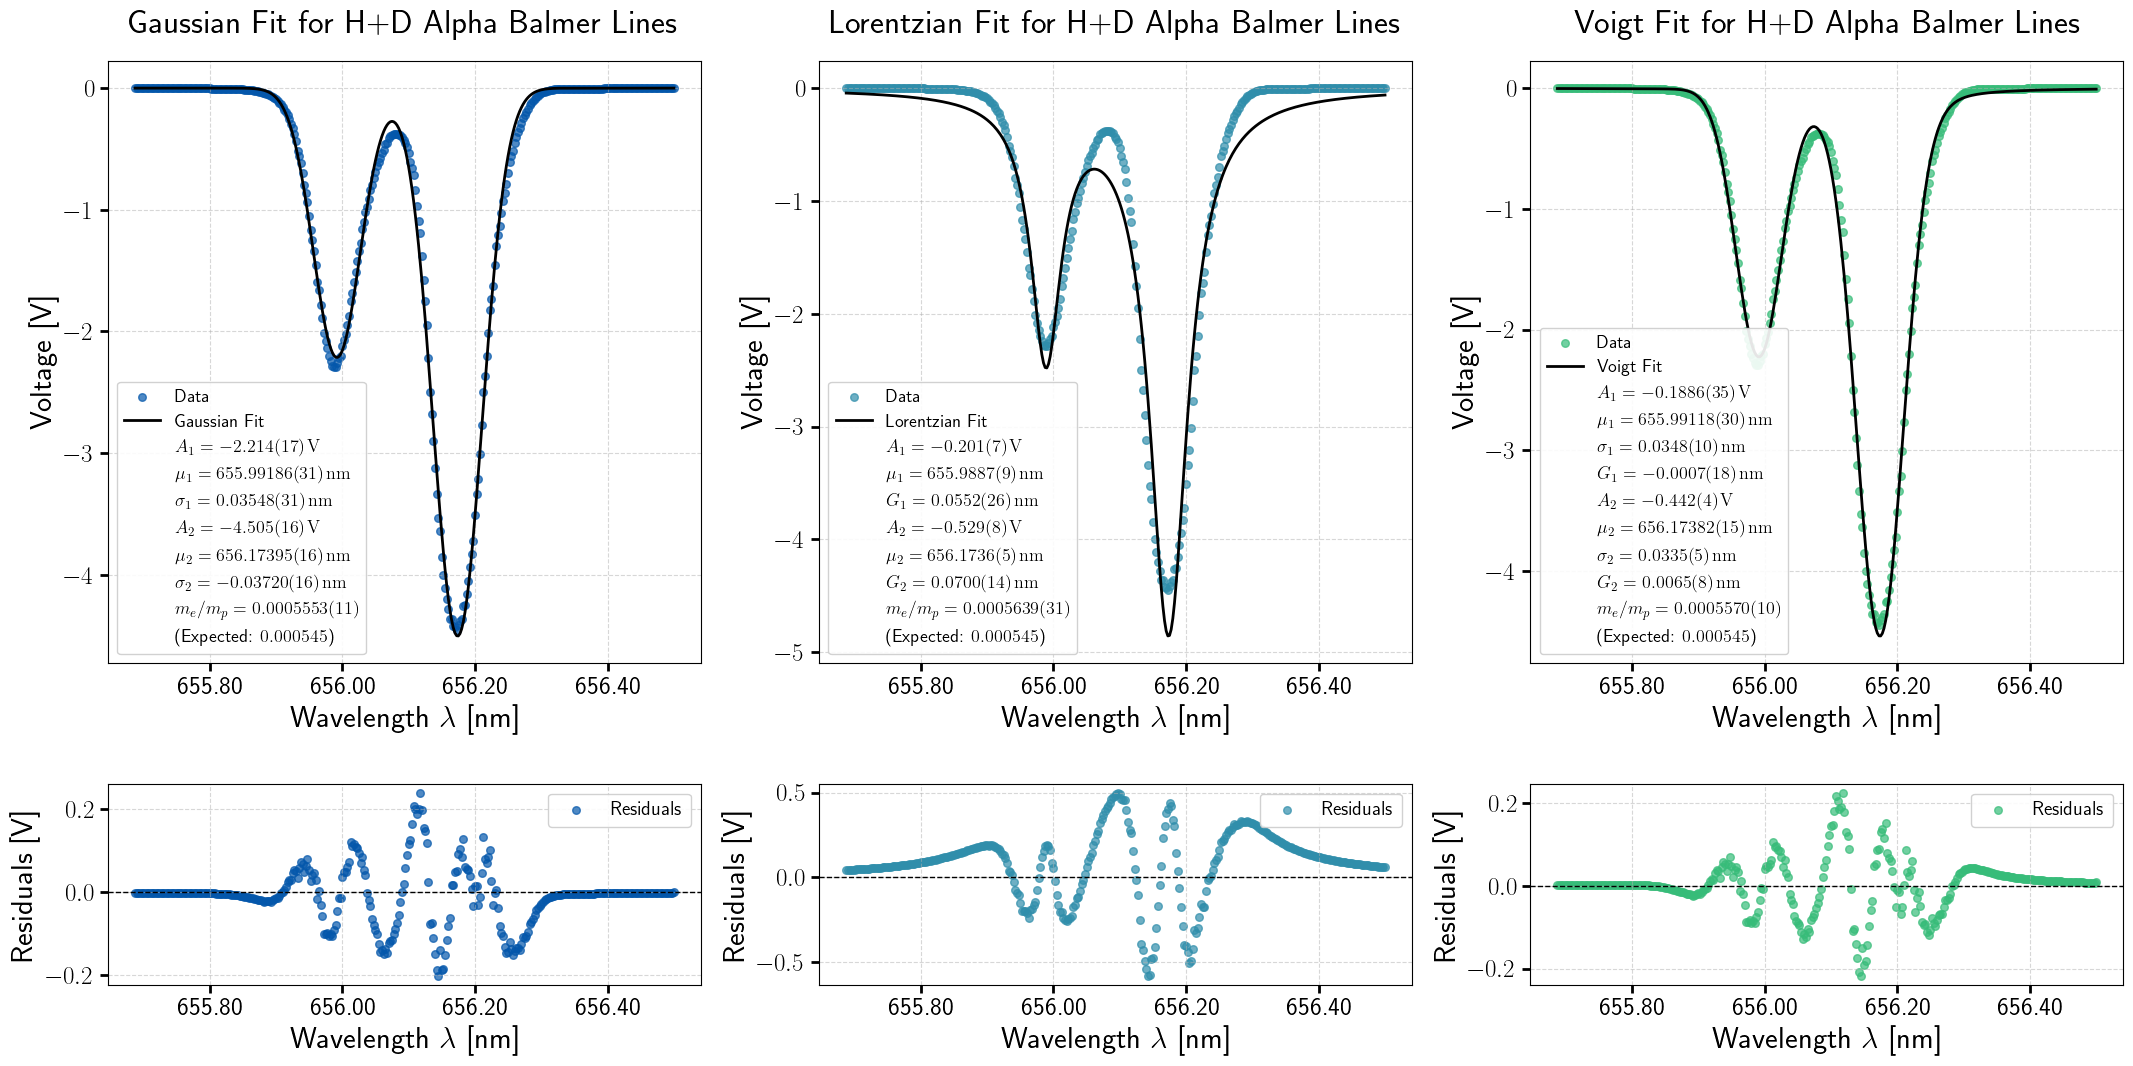

In [254]:
fig, axes = plot_all_fits('alpha', show_residuals=True, combined=True, n=3, use_frequency=False)
plt.tight_layout()
plt.savefig('alpha_HD_fits.pdf', bbox_inches='tight')
plt.show()

there are 203 data points in day3_betaHD.txt
calculating electron proton mass ratio with 485.38235+/-0.00019 485.51401+/-0.00008
calculating electron proton mass ratio with 485.3805+/-0.0015 485.5132+/-0.0006
calculating electron proton mass ratio with 485.38252+/-0.00018 485.51408+/-0.00008


C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\2374029236.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\411744011.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


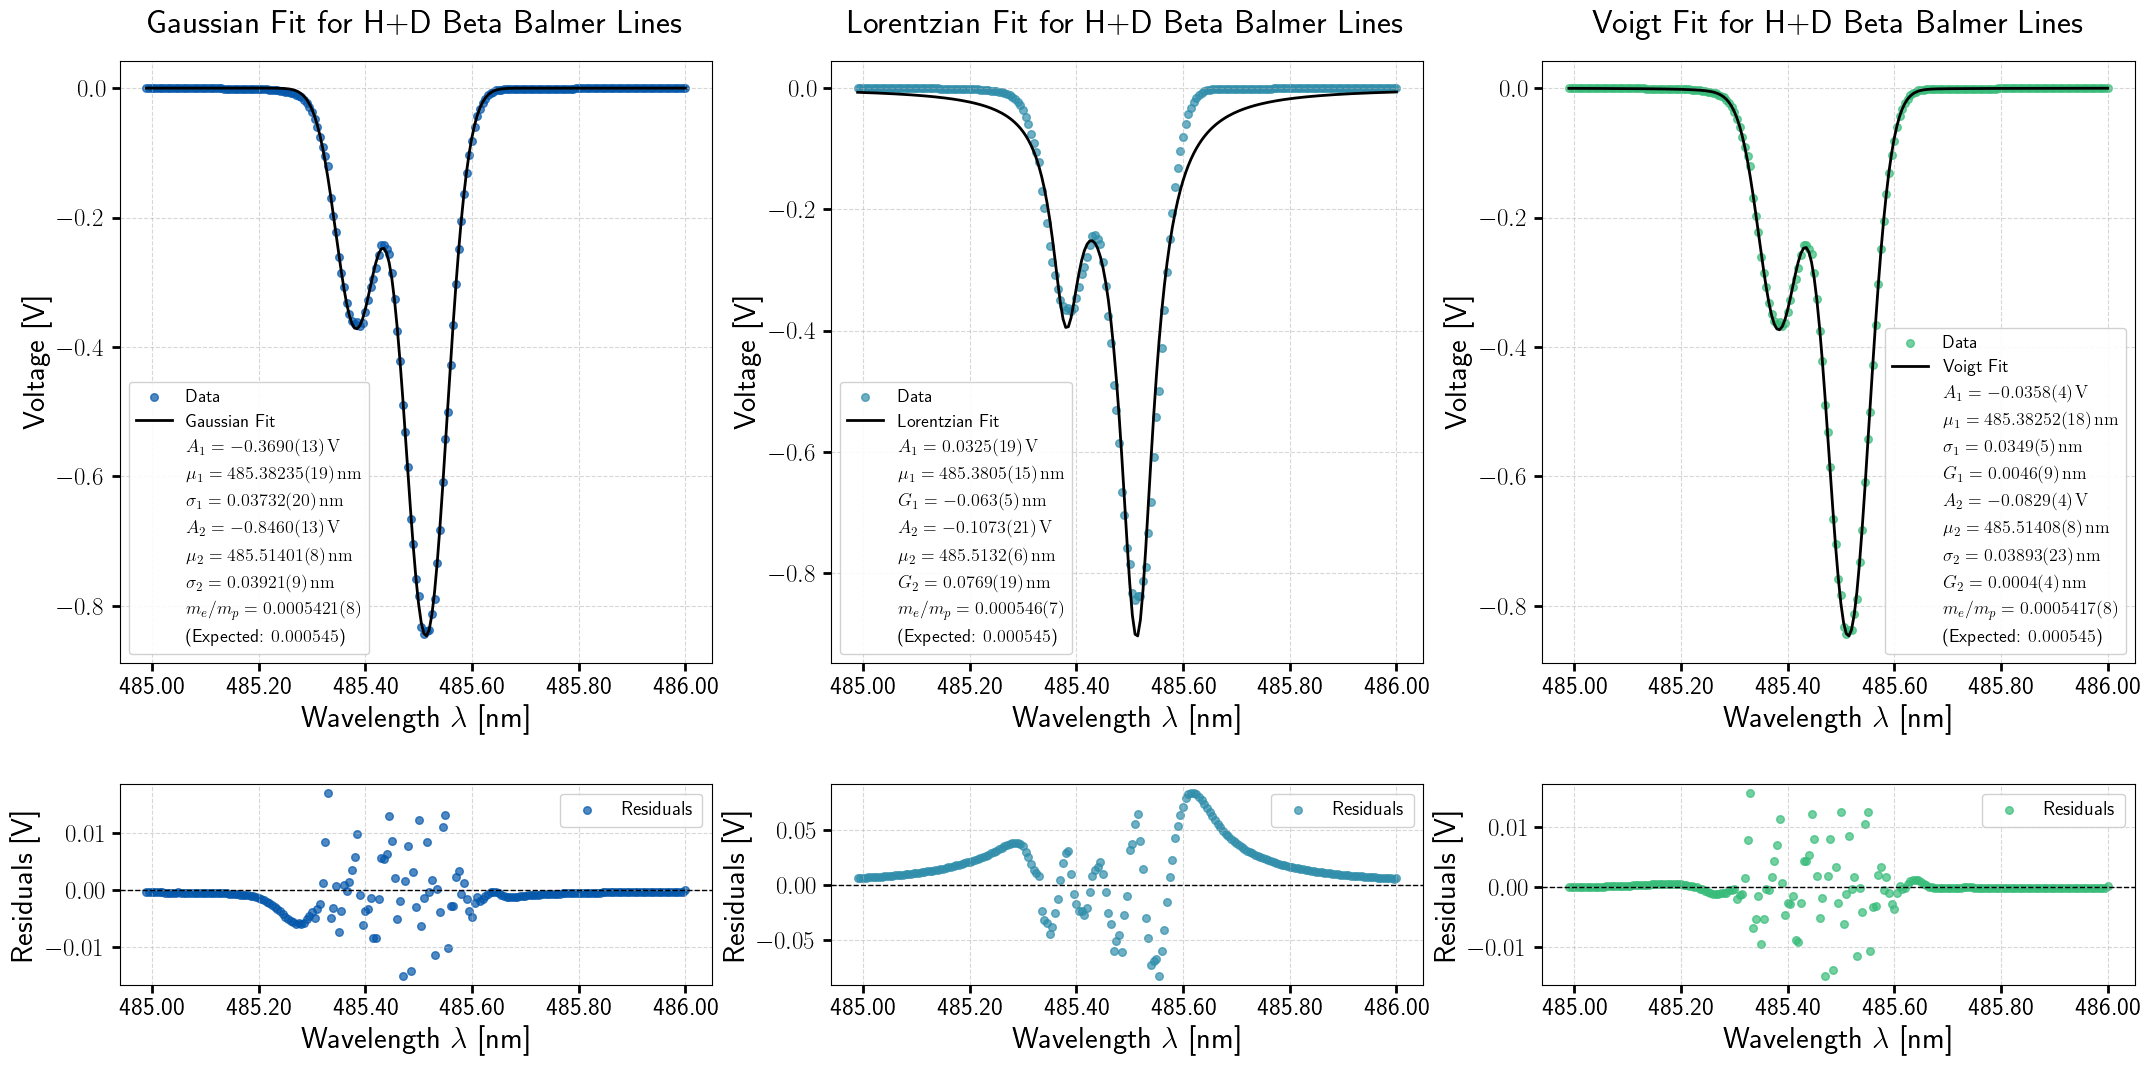

In [255]:
fig, axes = plot_all_fits('beta', show_residuals=True, combined=True, n=4, use_frequency=False)
plt.tight_layout()
plt.savefig('beta_HD_fits.pdf', bbox_inches='tight')
plt.show()

there are 103 data points in day3_gammaHD.txt
calculating electron proton mass ratio with 433.17198+/-0.00031 433.29488+/-0.00015
calculating electron proton mass ratio with 433.1713+/-0.0021 433.2933+/-0.0009
calculating electron proton mass ratio with 433.17215+/-0.00023 433.29480+/-0.00011


C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\2374029236.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\2964713088.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


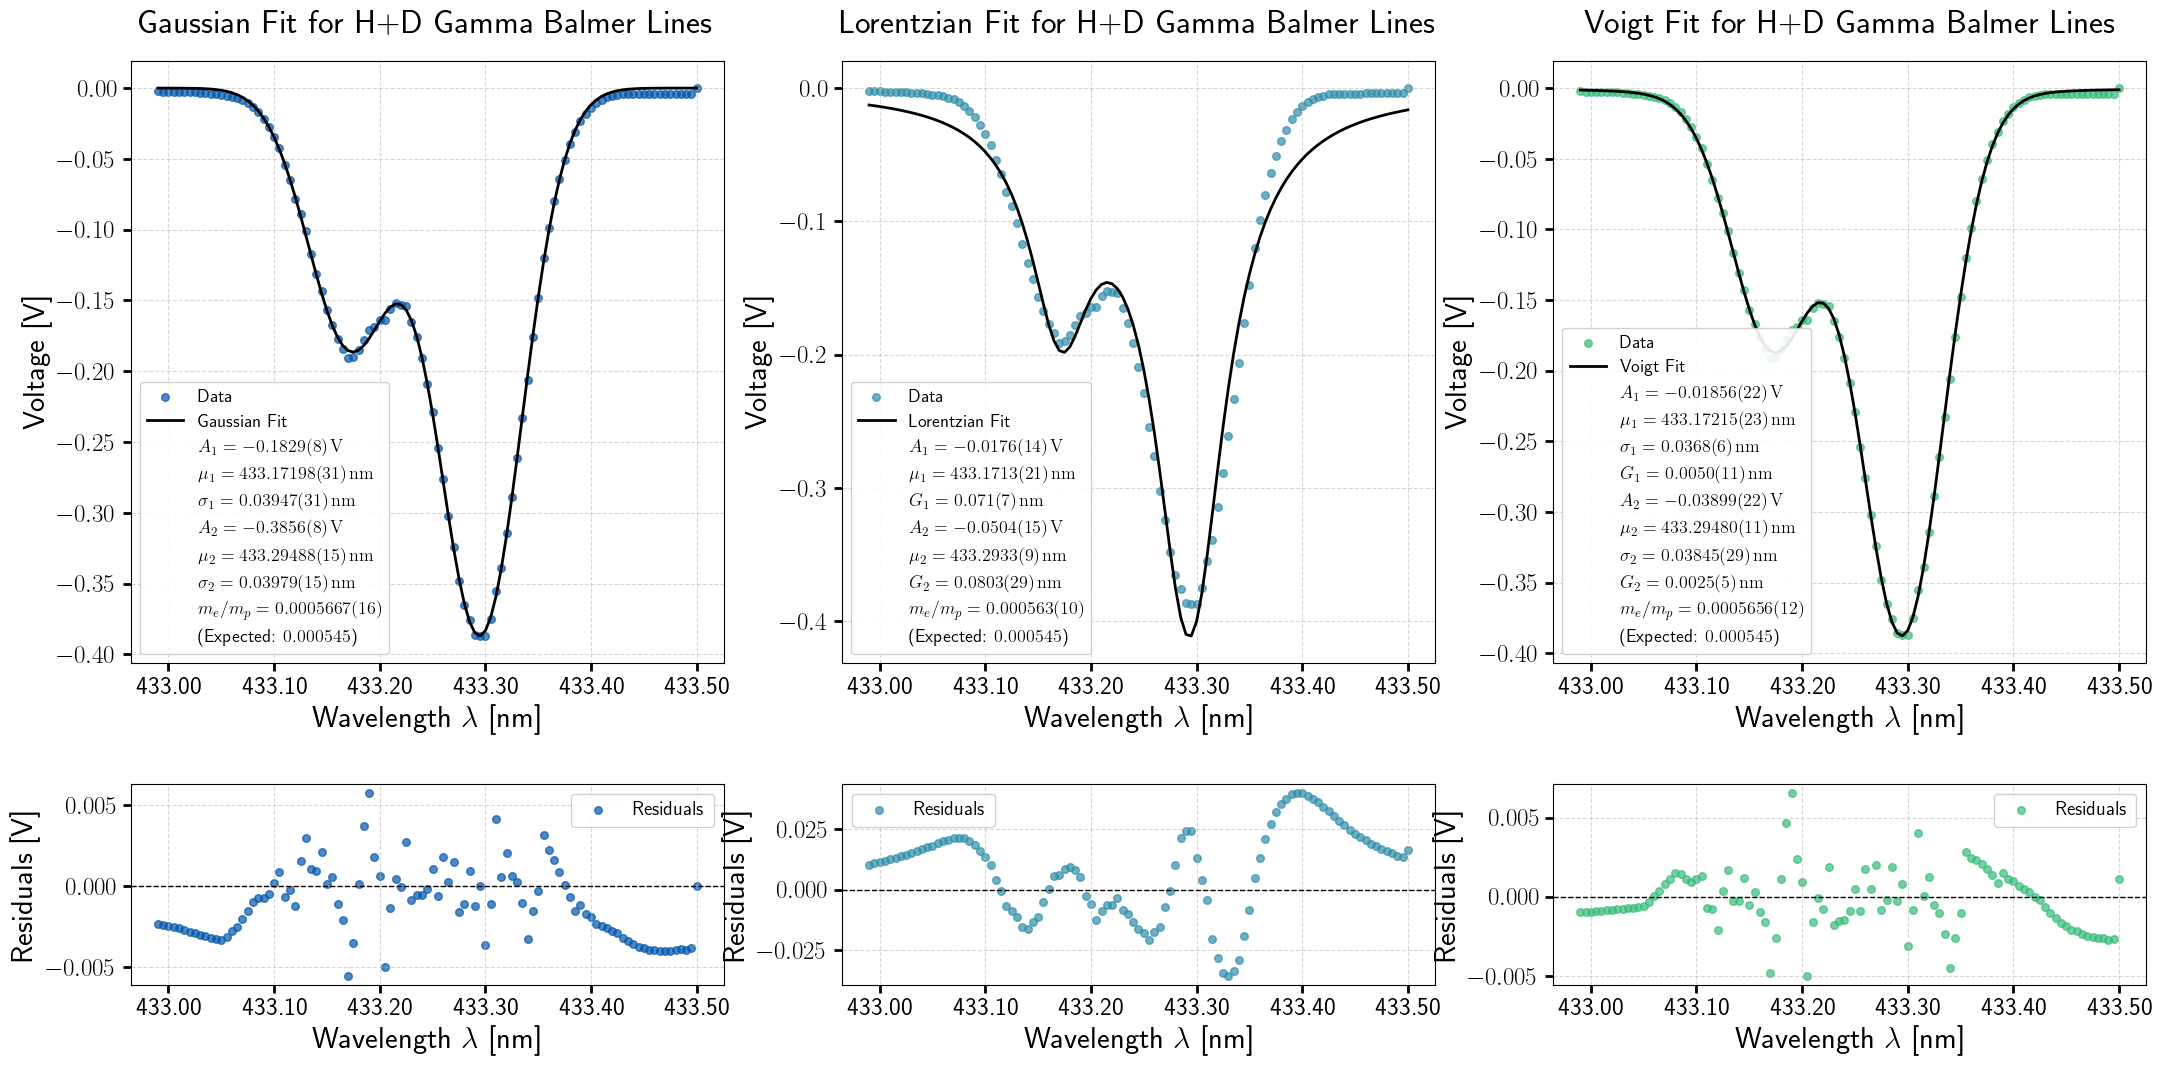

In [256]:
fig, axes = plot_all_fits('gamma', show_residuals=True, combined=True, n=5, use_frequency=False)
plt.tight_layout()
plt.savefig('gamma_HD_fits.pdf', bbox_inches='tight')
plt.show()

there are 83 data points in day4_delta.txt
calculating electron proton mass ratio with 409.2811+/-0.0017 409.3829+/-0.0006
calculating electron proton mass ratio with 409.2774+/-0.0019 409.3809+/-0.0006
calculating electron proton mass ratio with 409.2817+/-0.0008 409.38214+/-0.00024


C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\2374029236.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\alexa\AppData\Local\Temp\ipykernel_14668\709388038.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


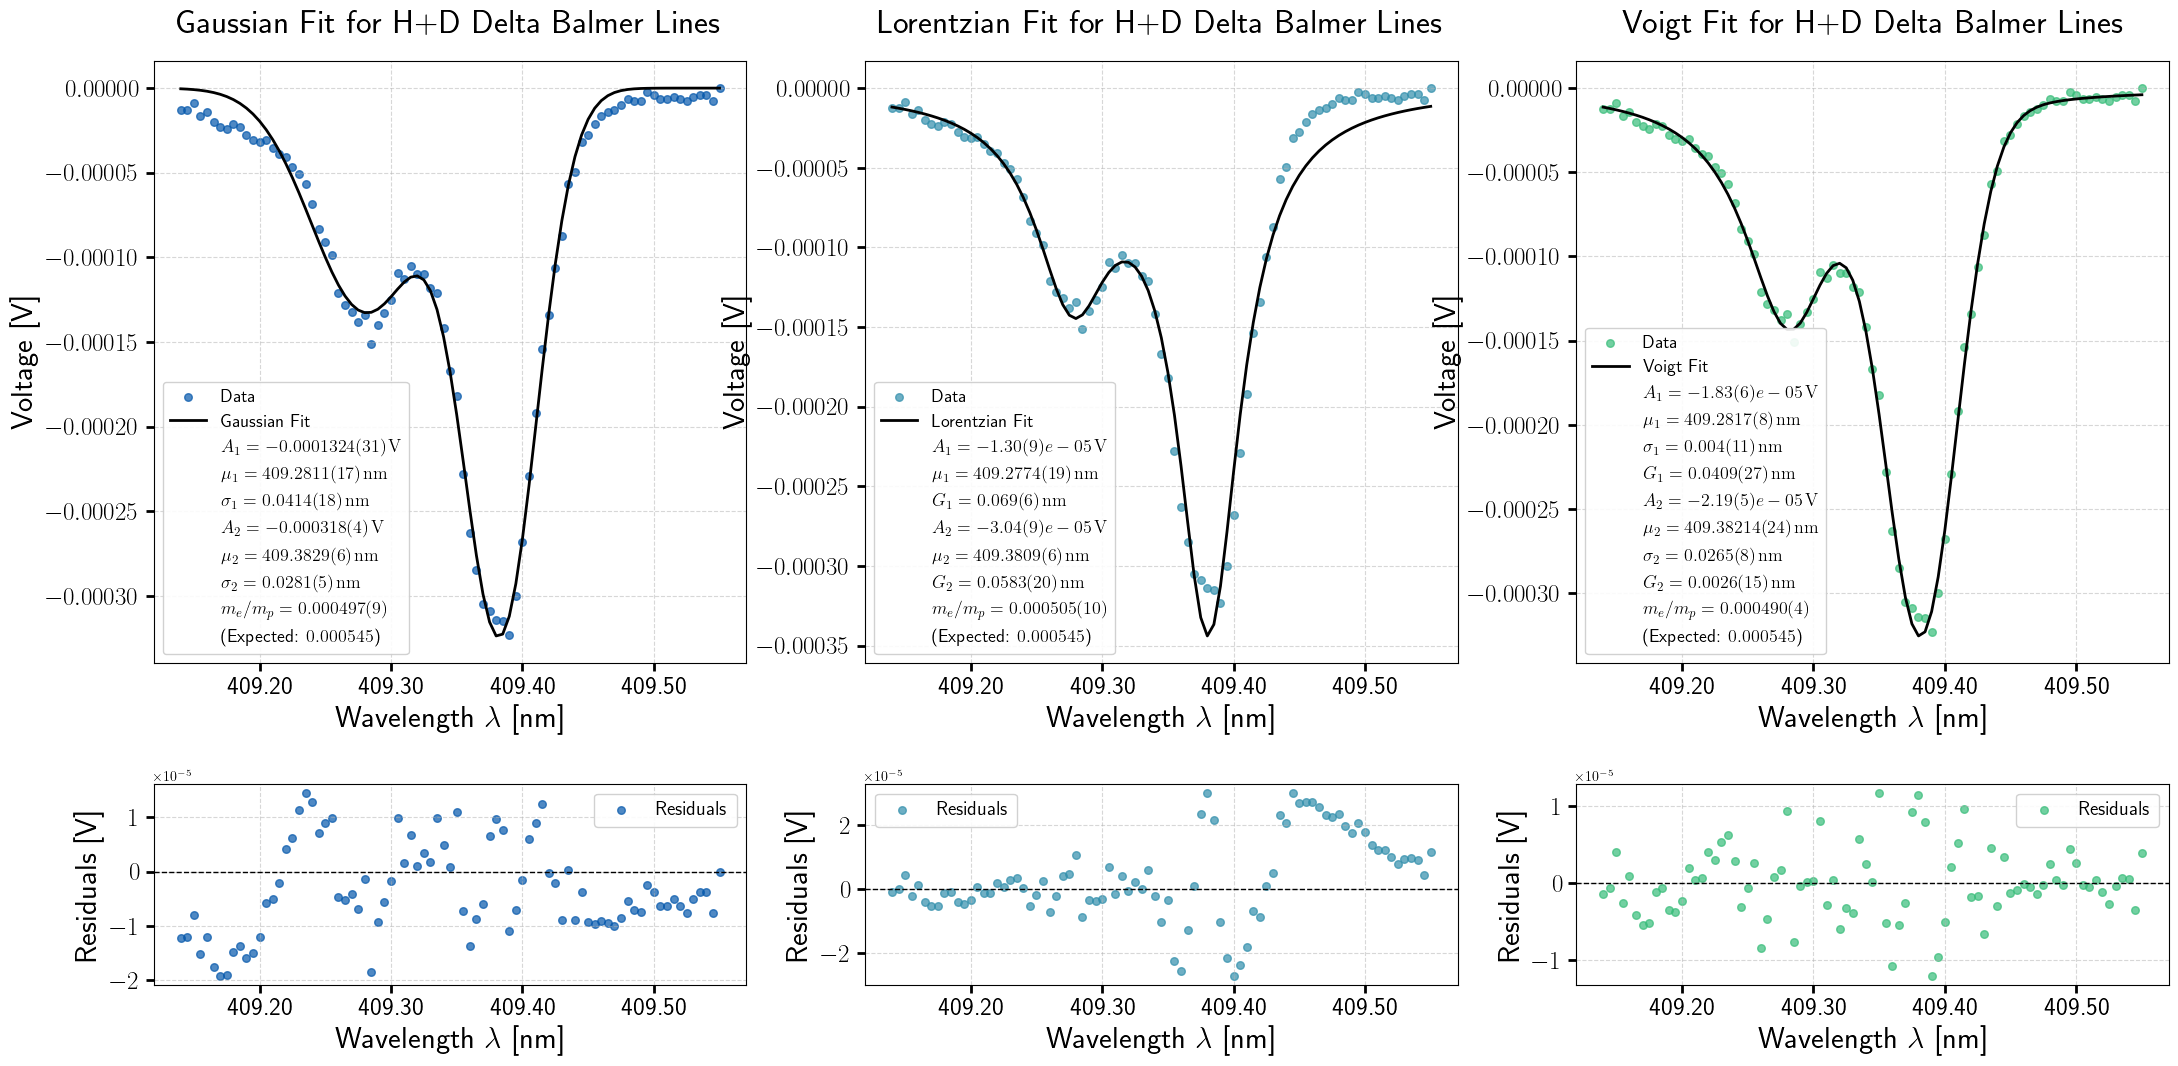

In [257]:
fig, axes = plot_all_fits('delta', show_residuals=True, combined=True, n=6, use_frequency=False)
plt.tight_layout()
plt.savefig('delta_HD_fits.pdf', bbox_inches='tight')
plt.show()

In [258]:
# fig, axes = plot_all_fits('alpha_old', show_residuals=True, combined=True)
# plt.tight_layout()
# plt.savefig('alpha_old_HD_fits.pdf', bbox_inches='tight')
# plt.show()